Summary: lets plot a scatterplot and some regressions of travel time w.r.t. grid time, dow, and grid pieces.

In [38]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats

## load the data

In [10]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [11]:
peakHours = (np.genfromtxt("..\Output_Data/peakHours.csv", delimiter=",", dtype = str))

with open("..\Input_Data/grid_info_multiple.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [55]:
peakHours[0]

array(['', 'IncidentForeignKey', 'Radio_Name', 'Longitude_At_Assign_Time',
       'Latitude_At_Assign_Time', 'Time_Assigned', 'Time_Enroute',
       'Time_ArrivedAtScene', 'Time_Depart_Scene',
       'Time_Arrive_Destination', 'Time_Available', 'Time_Call_Cleared',
       'Call_Disposition', 'Longitude_Of_Emergency',
       'Latitude_Of_Emergency', 'transport_time', 'grid_time'],
      dtype='<U30')

In [56]:
print(peakHours[0,3]) #Longitude_At_Assign_Time
print(peakHours[0,4]) #Latitude_At_Assign_Time
print(peakHours[0,5]) #Time_Assigned
print(peakHours[0,6]) #Time_Enroute
print(peakHours[0,7]) #Time_ArrivedAtScene
print(peakHours[0,8]) #Time_Depart_Scene
print(peakHours[0,9]) #Time_Arrive_Destination
print(peakHours[0,10]) #Time_Available
print(peakHours[0,11]) #Time_Call_Cleared
print(peakHours[0,13]) #Longitude_Of_Emergency
print(peakHours[0,14]) #Latitude_Of_Emergency
print(peakHours[0,15]) #travel_time
print(peakHours[0,16]) #grid_time

Longitude_At_Assign_Time
Latitude_At_Assign_Time
Time_Assigned
Time_Enroute
Time_ArrivedAtScene
Time_Depart_Scene
Time_Arrive_Destination
Time_Available
Time_Call_Cleared
Longitude_Of_Emergency
Latitude_Of_Emergency
transport_time
grid_time


## compare error with no adjustment
possibly adjust for dow, hour, number of grid tiles, specific path

In [57]:
import math
from datetime import *; from dateutil.relativedelta import *
import calendar
def csv2calendar(index,type_event):
    time1 = peakHours[index,type_event-1]  #note backend and clean data sets are off by one index
    #time1 = backend[index,type_event]
    if time1 == "":
        return -1
    [ymd,hmm] = time1.split()
    [y,m,d] = ymd.split('-')
    [h,minu,sec] = hmm.split(":")
    y = int(y)
    m = int(m)
    d = int(d)
    h = int(h)
    minu = int(minu)
    sec = math.floor(float(sec))
    timearrive = datetime(y, m, d, h, minu, sec)
    return timearrive

In [87]:
#this is a bad data structure. You could use a hashmap instead,it would have 3200*3200 entries though.
paths = np.zeros([3200, 3200], dtype=object)
for i in range(3200):
    for j in range(3200):
        paths[i,j] = []

In [224]:
#this is a bad data structure. You could use a hashmap instead,it would have 3200*3200 entries though.
grid_paths = np.zeros([3200, 3200], dtype=object)
for i in range(3200):
    for j in range(3200):
        grid_paths[i,j] = []

In [128]:
len_paths =  np.zeros([3200, 3200])
for i in range(3200):
    for j in range(3200):
        len_paths[i,j] = len(paths[i,j])

In [219]:
np.where(len_paths > 100)

(array([ 824,  824,  824,  824,  824,  824,  824,  824,  824,  824, 1132,
        1132, 1132, 1132, 1132, 1132, 1132, 1132, 1132, 1194, 1194, 1194,
        1194, 1866], dtype=int64),
 array([ 641,  642,  701,  712,  762,  765,  769,  822,  825,  889,  712,
         769,  889, 1010, 1011, 1012, 1070, 1071, 1131, 1071, 1320, 1378,
        1379, 1623], dtype=int64))

In [220]:
len_paths[824,641]

130.0

In [232]:
float(peakHours[i,13]) - float(peakHours[i,3])

0.15973799999999017

In [233]:
nsamples = 10000 #len(peakHours)
error_list = []
error_percent = []
grid_list = []
report_list = []
hour_list = []
start_list = []
end_list = []
delta_x_list = []
delta_y_list = []
grid_zero_count = 0
for i in range(1,nsamples):
    start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
    end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
    grid_time = g.get_time(start_pt,end_pt)
    reported_time = float(peakHours[i,15])
    #remove 'bad' data
    if(grid_time == 0) or (start_pt < 0) or (start_pt > 3200): #6 points are out of region index..
        grid_zero_count = grid_zero_count + 1
        continue
    if(reported_time > 10000):
        continue
    grid_list.append(grid_time)
    
    start_list.append(start_pt)
    end_list.append(end_pt)
    report_list.append(reported_time)
    error_list.append(reported_time -  grid_time)
    paths[start_pt,end_pt].append(reported_time)
    grid_paths[start_pt,end_pt].append(grid_time)
    delta_x_list.append(float(peakHours[i,14]) - float(peakHours[i,4]))
    delta_y_list.append(float(peakHours[i,13]) - float(peakHours[i,3]))
    #time
    Time_Enroute = csv2calendar(i,7)
    hour_list.append(Time_Enroute.hour)
grid_zero_count

805

In [242]:
2000/60

33.333333333333336

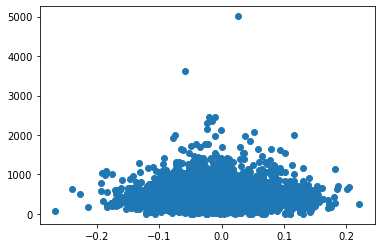

In [241]:
plt.scatter(delta_x_list,report_list)

In [238]:
#use everything to predict log(reported_time)
data = np.array([np.array(delta_x_list),np.array(delta_y_list),np.array(grid_list),np.array(report_list)])
data = data.transpose()
df = pd.DataFrame(data, columns = ['deltaX','deltaY','grid_time','report_time'])
X = df[['deltaX', 'deltaY','grid_time']]
y = df['report_time']   
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)
#generate r^2 value
from sklearn.metrics import r2_score
y_pred = []
for i in range(len(report_list)):
    y_pred.append(regr.predict([[delta_x_list[i], delta_y_list[i], grid_list[i]]]))
r2_score(report_list, y_pred)
#normal 0.046397200099616454
#log 0.03547441423973152
#add hour log 0.035680215875491195

0.046515370692133406

In [47]:
##  linear regression

r-squared: 0.0008290617723345471


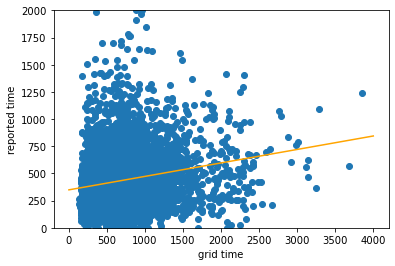

In [102]:
#linear regression on time slots
slope, intercept, r_value, p_value, std_err = stats.linregress(grid_list,report_list)
x = np.linspace(0, 4000, num=50)
y = slope * np.linspace(0, 4000, num=50) + intercept
plt.plot(x,y, 'orange')
plt.scatter(grid_list, report_list)
plt.ylim([0,2000])
plt.xlabel("grid time")
plt.ylabel("reported time")
print("r-squared:", r_value**2)

In [1]:
#linear regression on log time slots
log_report_list = np.log(report_list)
slope, intercept, r_value, p_value, std_err = stats.linregress(grid_list,log_report_list)
x = np.linspace(0, 4000, num=50)
y = slope * np.linspace(0, 4000, num=50) + intercept
plt.plot(x,y, 'orange')
plt.scatter(grid_list, log_report_list)
plt.ylim([0,10])
plt.xlabel("grid time")
plt.ylabel("log of reported time")
print("r-squared:", r_value**2)

NameError: name 'np' is not defined

1
r-squared: 0.051104413623035146


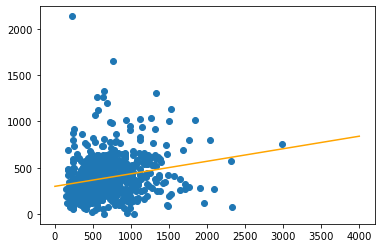

In [216]:
#plot a specific hour
hour_list = np.array(hour_list)
report_list = np.array(report_list)
grid_list = np.array(grid_list)
hour8ind = np.where(hour_list == 13)
print(len(hour8ind))
slope, intercept, r_value, p_value, std_err = stats.linregress(grid_list[hour8ind],report_list[hour8ind])
x = np.linspace(0, 4000, num=50)
y = slope * np.linspace(0, 4000, num=50) + intercept
plt.plot(x,y, 'orange')
plt.scatter(grid_list[hour8ind], (report_list[hour8ind]))
print("r-squared:", r_value**2)

In [180]:
#sns.heatmap(len_paths,linewidths = 0)

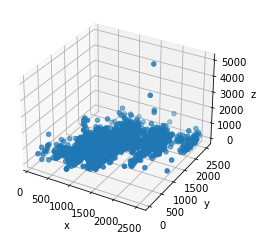

In [147]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(start_list, end_list, report_list)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
#delta x delta y regression?

In [177]:
#use input and output long and lat to predict log(reported_time)
log_report_list = np.log(report_list)
data = np.array([np.array(start_list),np.array(end_list),log_report_list])
data = data.transpose()
df = pd.DataFrame(data, columns = ['start_pt','end_pt','report_time'])
X = df[['start_pt', 'end_pt']]
y = df['report_time']   
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)
#generate r^2 value
from sklearn.metrics import r2_score
y_pred = []
for i in range(len(report_list)):
    y_pred.append(regr.predict([[start_list[i], end_list[i]]]))
r2_score(log_report_list, y_pred)

0.0005932190948924054

In [179]:
data = np.array([np.array(start_list),np.array(end_list),report_list])
data = data.transpose()
df = pd.DataFrame(data, columns = ['start_pt','end_pt','report_time'])
X = df[['start_pt', 'end_pt']]
y = df['report_time']   
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)
#generate r^2 value
from sklearn.metrics import r2_score
y_pred = []
for i in range(len(report_list)):
    y_pred.append(regr.predict([[start_list[i], end_list[i]]]))
r2_score(report_list, y_pred)

0.0005066142826413156

In [201]:
#use everything to predict log(reported_time)
log_report_list = np.log(report_list)
data = np.array([np.array(start_list),np.array(end_list),np.array(grid_list),np.array(hour_list),np.array(report_list)])
data = data.transpose()
df = pd.DataFrame(data, columns = ['start_pt','end_pt','grid_time','hour','report_time'])
X = df[['start_pt', 'end_pt','grid_time', 'hour']]
y = df['report_time']   
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)
#generate r^2 value
from sklearn.metrics import r2_score
y_pred = []
for i in range(len(report_list)):
    y_pred.append(regr.predict([[start_list[i], end_list[i], grid_list[i], hour_list[i]]]))
r2_score(report_list, y_pred)
#normal 0.046397200099616454
#log 0.03547441423973152
#add hour log 0.035680215875491195


0.046399336490412835

(array([64., 59., 35., 20.,  5., 22.,  0.,  0.,  0.,  5.]),
 array([ 233. ,  323.3,  413.6,  503.9,  594.2,  684.5,  774.8,  865.1,
         955.4, 1045.7, 1136. ]),
 <BarContainer object of 10 artists>)

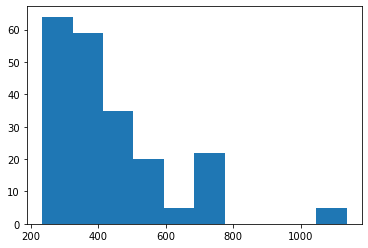

In [223]:
plt.hist(paths[824,641])

specify : gird path i to j
boxplot
1) trim the 5% quantiles
2) plot grid time vs reported time
3) (include delta x and delta y)
4) 4.44 + .3 x (check your answer later)
5) log-log transform data? (make sure residuals are constant)
6) 